In [ ]:
# Install GUDHI
!pip install ripser umap-learn kmapper persim PersistenceImages
!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install tomaster Boruta
!pip install gudhi

     |████████████████████████████████| 72 kB 507 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 8.0 MB/s 
     |████████████████████████████████| 125 kB 49.9 MB/s 
     |████████████████████████████████| 47 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 54.0 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=456091 sha256=f5673ac122c0401cc2392997b51c9f8c8e2dd8d7b2a60882e6355692e31236fe
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=6b92533bd820da1db5d11cc7f6189edb558837e936c35ca0842df91935ecbd51
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.

In [ ]:
import numpy as np
import pandas as pd
import gudhi as gd
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.stattools import acf
import os
import math
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/Geometric_Methods/Project/data"
os.path.isdir(data_dir)

True

## 1- Persistence Landscapes

> In this section, we aim to build persistence landscapes given an input persistence diagram $D$. 

#### a) Introducing Persistence Landscapes

> In this section, we will discuss the steps taken to build the persistence landscape of a point cloud.

> Persistence landscapes are computed by first applying Rips Filtration to a point of cloud (the method is discussed in detail in the paper we were given to study but isn't the main focus of this project). Briefly, a point cloud $X$ can be associated to a topological space by introducing Vietoris-Rips simplicial complexes $R(X,\epsilon),\epsilon>0$ defined as:


*   For each $k=0,1...$, a k-simplex of vertices $\left\{ x_{i_1},...,x_{i_k} \right\}$ is part of $R(X,\epsilon)$ if and only if the mutual distance between any pair of its vertices is less than $\epsilon$, i.e.
$$ \forall x_{i_j},x_{i_l}, d(x_{i_j},x_{i_l}) < \epsilon $$

> These simplicial complexes inherit a natural filtration structure: $\forall \epsilon < \epsilon', R(X,\epsilon) \subseteq R(X,\epsilon')$. For each of these complexes, we can compute the associated k-dimensional homologies $H_k(R(X,\epsilon))$ which benefit from the same filtration properties: $\forall \epsilon < \epsilon', H_k(R(X,\epsilon)) \subseteq H_k(R(X,\epsilon'))$.

> We can then apply Rips Filtration to all k-dimensional homologies and encode them into persistence diagrams $P_k$. For each $k$-dimensional homology class $\alpha$, we can associate a pair $(b_\alpha,d_\alpha) \in \mathbb{R}^2$ of respectively birth and death indices. Essentially, their existence is ensured using the filtration property mentionned above and they correspond respectively to the smallest and largest value of $\epsilon$ for which $\alpha \in H_k(R(X,\epsilon))$. The induced persistence diagram $P_k$ is thus a set of pairs $P_k = \left\{ (b_\alpha,d_\alpha) | \alpha \in \bigcup_{\epsilon \geq 0} H_k(R(X,\epsilon)) \right\}$ which can be represented in the plane.

> Though the space of persistence diagrams $\mathcal{P}$ endowed with the Wasserstein distance $\mathcal{W}_p$ forms a metric space $(\mathcal{P},\mathcal{W}_p)$, it is not complete thus isn't an adapted space for statistical treatment. This is the reason why we introduce persistence landscapes which enable a representation of persistence diagrams in the Banach space $L^p(\mathbb{N} \times \mathbb{R})$.

> Let $(b_\alpha,d_\alpha) \in P_k$, we define the following function:
$$
f_{(b_\alpha,d_\alpha)}(x) =
\left\{
	\begin{array}{ll}
		x-b_\alpha  & \mbox{if } x \in [b_\alpha,\frac{b_\alpha + d_\alpha}{2}] \\
		-x + d_\alpha & \mbox{if } x \in ]\frac{b_\alpha + d_\alpha}{2},d_\alpha] \\
    0  & \mbox{if } x \notin [b_\alpha,d_\alpha]
	\end{array}
\right.
$$

> Consider a persistence diagram $P_k$ with a finite number of off-diagonal points. Let $l \in \mathbb{N}$, we define the function $λ_l:\mathbb{R} ⟶ [0,1]$ as the following:
$$
\lambda_l(x) = l-max \left\{ f_{(b_\alpha,d_\alpha)}(x) | (b_\alpha,d_\alpha) \in P_k \right\}
$$
where $l-max$ defines the $l$-th largest value of a set. For any $l > |P_k| $, we set $\lambda_l = 0$.
> Finally, the persistence landscape $\lambda$ is defined as the family $(\lambda_l)_{l \in \mathbb{N}}$ of $L^p(\mathbb{N} \times \mathbb{R}), \forall p \in \mathbb{N}^*$. When endowed with the $L^p$ norm, the space of persistence landscapes lies within a Banach space. 




#### b) Computing Persistence Landscapes

> We will now implement a function able to compute persistence landscapes and discuss the paradigm choices made for this implementation.

> We are required to implement the persistence landscape given the following parameters: an persistence diagram $D$ in the GUDHI format, a dimension $k$, the endpoints $x_{min},x_{max}$ of an interval, the number $n$ of nodes of a regular grid on the interval $[x_{min},x_{max}]$ and a number of landscapes $m$.


*   A persistence diagram in Gudhi is represented as a list of tuples, with each tuple corresponding to a homology class. The latter is represented as follows: $(dimension,(b_\alpha,d_\alpha))$ where $dimension$ is the dimension of the homology class $\alpha$ and $(b_\alpha,d_\alpha)$ are respectively the birth and death values of $\alpha$.
*   $k$ represents the dimension of the homology classes we consider. As mentionned above, a persistence diagram $P_k$ is computed with regards to the homologies of dimension k, thus, the persistence landscape also.

> We now discuss our implementation choice. In the spirit of the Gudhi framework, we decide to implement the persitence diagram in an Object Oriented manner. We thus define a class $PersistenceLandscape$ with the following characteristics:


---


**PersistenceLandscape**

*Attributes:*

*   $k$ (integer): the homology dimension.
*   $x_{min},x_{max}$ (float): the endpoints of the interval.
*   $n$ (integer): the number of nodes in the regular grid.
*   $m$ (integer): the number of landscapes.
*   $landscapes$ (integer array): an array containing the values of the $m$ landscapes at each of the $n$ nodes of the regular grid.

*Methods:*

*   $build\_landscape$: takes as input the parameters mentionned above, computes the landscapes matrix and updates the attributes of the class.



---



> Note that, because of the current simplicity of the class, taking an Object Oriented approach is not necessary. We still decided to follow this approach considering it offers the best framework to further complexify and add methods. 

> We now describe the $build\_landscape$ algorithm used to build the persistence landscape of a given persistence diagram:



---



$build\_landscape$

**Inputs:** $D$ persistence diagram, $k$ dimension of the homology, $x_{min},x_{max}$ the endpoints of the interval, $n$ the number of nodes in the regular grid, $m$ the number of landscapes.

**Algorithm:**



1.   Filter through $D$ to keep homology classes of dimension $k$ (we name the resulting list $D_{filtered}$).
2.   Compute $f_{(b_\alpha,d_\alpha)}$ on the regular grid defined by $x_{min},x_{max},n$ for each homology class $\alpha$ in $D_{filtered}$. This induces a matrix $f$ of dimension $|D_{filtered}| \times n$.
3.   Order each column of $f$ in descending order. Each row of the resulting $f_{ordered}$ corresponds to the $l-max$ vector of $f$ over the grid. Thus, we have computed the $|D_{filtered}|$ first persistence landscape vectors of our point cloud.
4.   Compute the persistence landscapes matrix $landscapes$ by restricting or expanding the number of rows of $f_{filtered}$ to $m$.
5.   Update the attributes of the $PersistenceLandscape$ object.


---

> Naturally, we will need to implement an annex function $compute\_f$ which takes a couple of birth and death values $b_\alpha,d_\alpha$, a real value $x$ and returns $f_{(b_\alpha,d_\alpha)}(x)$.

> Once implemented, we will test the correctness of our algorithm on simple examples.

#### Implementation

In [ ]:
def compute_f(x,b,d):
    """
    Computes f_(b,d)(x).
    """
    # If x is outside of the interval, return 0
    if x <= b or x >= d:
        return 0
    # If x is in the first half of the interval
    elif x <= (b+d)/2:
        return x - b
    # If x is in the second half of the interval
    else:
        return -x + d

In [ ]:
class PersistenceLandscape:

    def __init__(self):
        # Initialize all parameters to None
        self.k = None
        self.xmin,self.xmax = None,None
        self.n = None
        self.m = None
        self.landscapes = None

    def build_landscape(self,D,k,xmin,xmax,n,m):
        # Filter through d and only keep homology classes of dimension k
        D_filt = [(hmlg_clss[1][0],hmlg_clss[1][1]) for hmlg_clss in D if hmlg_clss[0] == k and hmlg_clss[1][1] < math.inf]

        # Compute regular grid
        grid = np.linspace(xmin,xmax,n)

        # Run through each homology class, compute associated f vector and create the f matrix
        f = []
        for hmlg_clss in D_filt:
            b,d = hmlg_clss
            # Run through grid and compute f value at each point
            f_val = [compute_f(x,b,d) for x in grid]
            # Append to final matrix
            f.append(f_val)
        
        # Convert into array and sort each column in descending order
        f = np.array(f)
        landscapes = -np.sort(-f, axis=0)

        # Pad landscapes with 0s or delete rows according to m value
        # Handle case where homology class is empty
        if landscapes.shape[0] == 0:
            self.landscapes = np.zeros((m,n))
        elif landscapes.shape[0] < m:
          # Pad with 0s
          padding = m - landscapes.shape[0]
          self.landscapes = np.pad(landscapes,[(0,padding),(0,0)],mode='constant', constant_values=0)
        else:
          # Restrict to first m rows
          self.landscapes = landscapes[:m,:]

#### Testing

> We now aim to test our algorithm against simple examples. 

> First, we sample a normally distributed cloud of points in the plane. We then use Gudhi to apply Rips filtration and obtain the resulting persistence diagram for dimensions 0 and 1. Finally, we compute the persistence landscapes using the Gudhi method and our implemented solution. We compare the results of both solutions to ensure the correctness of our approach.

In [ ]:
# Generate random sample of points
N = 50
mean = [0,0]
cov = [[1,0],[0,1]]

X = np.random.multivariate_normal(mean,cov,size=N)

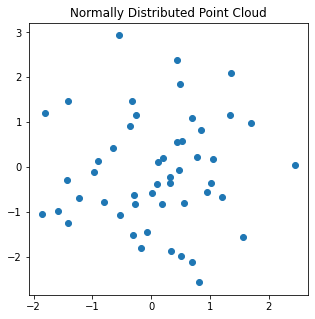

In [ ]:
# Plot cloud of points
plt.figure(figsize=(5,5))
plt.title("Normally Distributed Point Cloud")
plt.scatter(X[:,0],X[:,1])
plt.show()

In [ ]:
# Create Rips Complex and apply filtration
rips_complex = gd.RipsComplex(points=X)
rips_simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
barcodes_rips = rips_simplex_tree.persistence()

In [ ]:
# Look at the first 10 barcodes
for barcode in barcodes_rips[:10]:
    print(barcode)

(1, (1.0412278235415344, 1.256949901974078))
(1, (0.8233527673607287, 1.0205335089529548))
(1, (0.9340086395507936, 1.10699454478901))
(1, (0.5285403833083334, 0.6845894684694219))
(1, (0.44165123846785354, 0.593662454932051))
(1, (0.9048491247745798, 1.023795500206825))
(1, (0.8760544419562094, 0.8943544863881894))
(1, (0.3908268581836956, 0.40264157535183215))
(1, (0.6238982248253508, 0.6303377290847347))
(0, (0.0, inf))


usetex mode requires TeX.


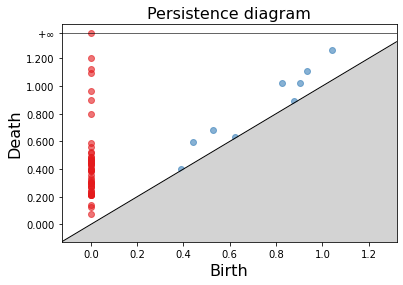

In [ ]:
# Plot persistence diagram
gd.plot_persistence_diagram(barcodes_rips)
plt.show()

In [ ]:
# Define persistence landscapes parameters
k = 0
xmin,xmax = 0,1
n = 100
m = N
persistence_landscape = PersistenceLandscape()

In [ ]:
# Compute persistence landscapes using our implementation
persistence_landscape.build_landscape(barcodes_rips,k,xmin,xmax,n,m)
landscapes = persistence_landscape.landscapes

In [ ]:
# Compute persistence landscapes with Gudhi
from gudhi.representations import Landscape

# Build diagonals vector from barcode_rips
D = [np.array([[barcode[0],barcode[1]] for dim,barcode in barcodes_rips if dim == k and barcode[1] < math.inf])]

# Fit landscape object to Rips diagram
gudhi_landscapes = Landscape(num_landscapes=m,resolution=n,sample_range=[xmin,xmax]).fit_transform(D).reshape(m,n)

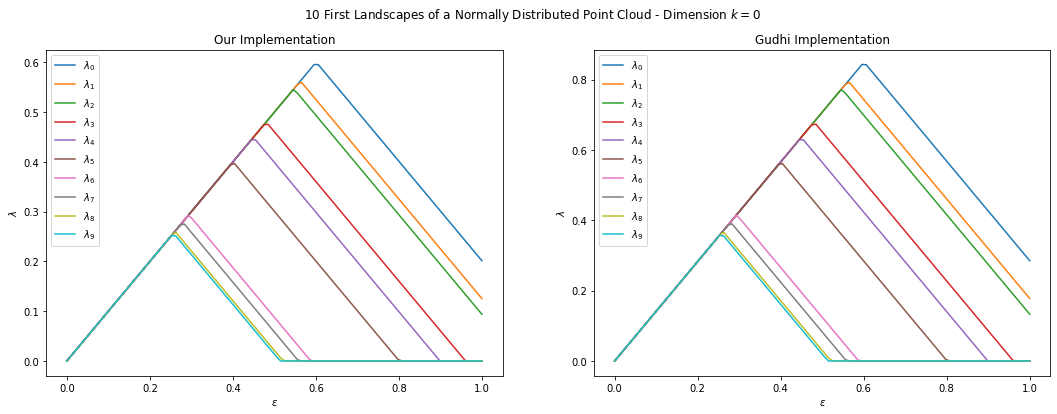

In [ ]:
# Plot both landscapes
grid = np.linspace(xmin,xmax,n)
fig, axs = plt.subplots(1,2,figsize=(18,6))
fig.suptitle("10 First Landscapes of a Normally Distributed Point Cloud - Dimension $k=0$")

axs[0].set_title("Our Implementation")
for i in range(10):
    axs[0].plot(grid,landscapes[i,:], label="$\lambda_{}$".format(i))
axs[0].legend()
axs[0].set_xlabel("$\epsilon$")
axs[0].set_ylabel("$\lambda$")

axs[1].set_title("Gudhi Implementation")
for i in range(10):
    axs[1].plot(grid,gudhi_landscapes[i,:], label="$\lambda_{}$".format(i))
axs[1].legend()
axs[1].set_xlabel("$\epsilon$")
axs[1].set_ylabel("$\lambda$")

plt.show()

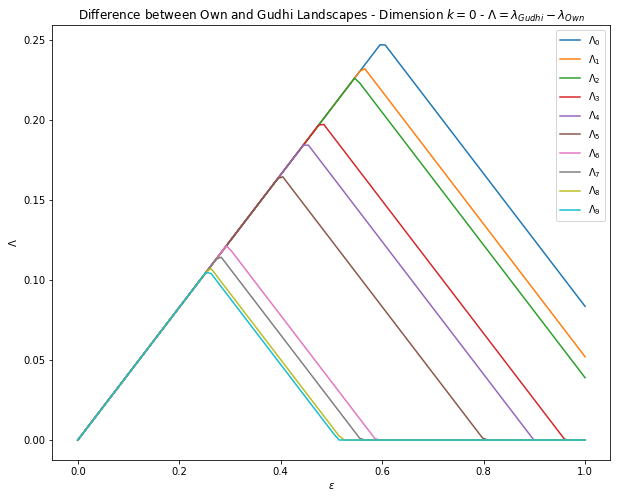

In [ ]:
# Plot the difference between the two landscapes
Lambda = gudhi_landscapes - landscapes

plt.figure(figsize=(10,8))
plt.title("Difference between Own and Gudhi Landscapes - Dimension $k=0$ - $\Lambda = \lambda_{Gudhi} - \lambda_{Own}$")
for i in range(10):
    plt.plot(grid,Lambda[i,:], label="$\Lambda_{}$".format(i))
plt.xlabel("$\epsilon$")
plt.ylabel("$\Lambda$")
plt.legend()
plt.show()

> It seems like there is a linear difference between our and Gudhi's implementations regarding the slopes of the landscapes. Indeed, after looking at the source code of Gudhi's Landscape class, we were able to identify a clear difference in how values of $f_{(b_\alpha,d_\alpha)}$ are computed over the regular grid.

> While we define a function that computes $f_{(b_\alpha,d_\alpha)}$ explicitly for each value of $x$ over the regular grid, Gudhi first computes the indexes of the three rupture points of $f_{(b_\alpha,d_\alpha)}$ on the regular grid. It then computes the values of $f_{(b_\alpha,d_\alpha)}$ sequentially by incrementing then decrementing by a constant step $\eta = \frac{x_{max}-x_{min}}{resolution}$. At first sight, the latter method seems more prone to errors as it makes more approximations while computing the rupture indexes. Indeed, $b_\alpha,d_\alpha,\frac{b_\alpha + d_\alpha}{2}$, in general, do not align with the regular grid. Moreover, Gudhi also defines the increment and decrement values using these approximations. This offset can be translated by a linearly increasing difference between the theoratical values of $f_{(b_\alpha,d_\alpha)}$ over the grid and the computed ones.

> A simple way to compare the correctness of both algorithms is thus to study the slopes, birth and death values of each computed landscapes. Visually, it seems like both algorithms coincide on the birth and death values of the landscapes. We will therefore concentrate our efforts on the landscapes' slopes. Considering $f_{(b_\alpha,d_\alpha)}$ have a slope of 1 or -1 when non-vanishing, and, by definition of the landscapes $\lambda_k$, computed over a finite set of off-diagonal points, the non-vanishing parts of each $λ_k$ should also have a slope of 1 or -1. We thus plot both landscapes against a linear slope of equation $y=x$ and compare the observations.

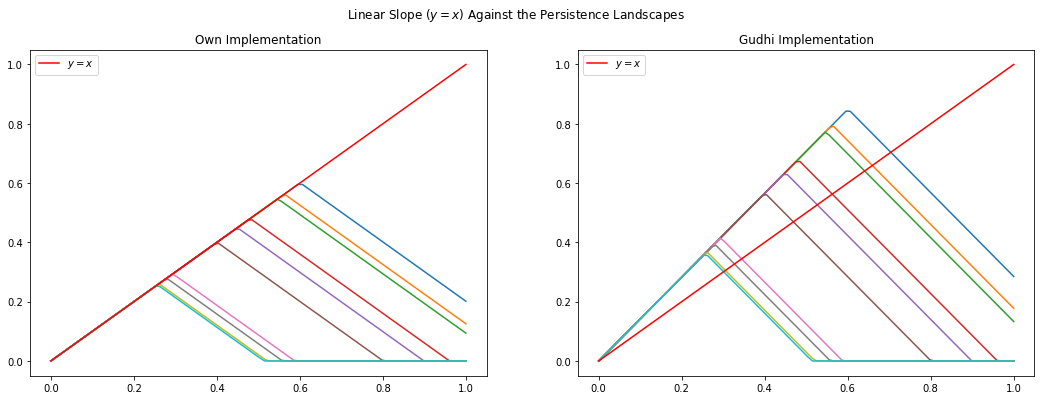

In [ ]:
grid = np.linspace(xmin,xmax,n)
fig, axs = plt.subplots(1,2,figsize=(18,6))

fig.suptitle("Linear Slope ($y=x$) Against the Persistence Landscapes")

axs[0].set_title("Own Implementation")
for i in range(10):
    axs[0].plot(grid,landscapes[i,:])
axs[0].plot(grid,grid,c='r', label="$y=x$")
axs[0].legend()

axs[1].set_title("Gudhi Implementation")
for i in range(10):
    axs[1].plot(grid,gudhi_landscapes[i,:])
axs[1].plot(grid,grid,c='r', label="$y=x$")
axs[1].legend()

plt.show()

> We observe that our landscapes are much better aligned with the linear equation and all have an increasing slope of 1. Given the observations made above, we can ensure the correctness of our approach and the lack of precision in Gudhi's implementation.

> Moreover, the lack of precision in Gudhi's approach does not appear to give any benefit complexity wise. Indeed, in both algorithms, values of $f_{(b_\alpha,d_\alpha)}$ are computed sequentially and in a linear manner. Therefore, it seems as our implementation gives better precision without compromise in computational time.

## 2- Application: Analyzing the Evolution of Daily Returns of Major US Stock Market

> In this section, we aim to reproduce the experiments led in Section 4 of [Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf) which analyze the daily time series of four US stock markets (S&P 500, DJIA, NASDAQ, Russell 2000) between December 23rd 1987 and December 8th 2016. They aim to apply TDA (Topological Data Analysis) and specifically study the properties of persistence homologies around the major economical crisis of the dotcom crash on 03/10/2000 and the Lehman bankruptcy on 09/15/2008. If successful, this work could introduce a new type of economic analysis able to detect imminent market crashes. We will follow the same steps as in the article using our implementation of the persistence landscapes. We will also continuously compare our results to the ones obtained by the article. 

> We first summarize the article's approach to the matter at hand. The study focuses on the daily log returns $r_{ij} = \log \left( \frac{P_{i,j}}{P_{i-1,j}} \right)$ of the adjusted closing values $P_{i,j}$ of each index $j$ and day $i$. This induces a multivariate time series of $\mathbb{R}^4$ for which we wish to explore persistence homologies properties. To do so, we introduce a sliding window $w$ (the article considers $w=50$ and $100$ and we will consider $w=40,80$ and $120$). We then slide the window accross the time series and consider the persistence properties of each of the sub-series induced by the sliding window. Each of these sub-series describes as a point cloud of $\mathbb{R}^4$ of size $w$ which can be represented in a $w \times 4$ size matrix. We represent the point cloud induced by indexes DJIA and NASDAQ around different days and different window sizes.

In [ ]:
# Import data
df_djia = pd.read_csv(os.path.join(data_dir,"DowJones.csv")).sort_values("Date")
df_nasdaq = pd.read_csv(os.path.join(data_dir,"Nasdaq.csv")).sort_values("Date")
df_russell = pd.read_csv(os.path.join(data_dir,"Russell2000.csv")).sort_values("Date")
df_sp = pd.read_csv(os.path.join(data_dir,"SP500.csv")).sort_values("Date")

# Compute log returns of each index
df_djia["djia"] = np.log(df_djia["Adj Close"]/df_djia["Adj Close"].shift(1))
df_nasdaq["nasdaq"] = np.log(df_nasdaq["Adj Close"]/df_nasdaq["Adj Close"].shift(1))
df_russell["russell"] = np.log(df_russell["Adj Close"]/df_russell["Adj Close"].shift(1))
df_sp["sp"] = np.log(df_sp["Adj Close"]/df_sp["Adj Close"].shift(1))

In [ ]:
# Merge all log returns into one dataframe and remove nan row
df_lr = df_djia[["Date","djia"]].merge(df_nasdaq[["Date","nasdaq"]],how="inner",on="Date")
df_lr = df_lr.merge(df_russell[["Date","russell"]],how="inner",on="Date")
df_lr = df_lr.merge(df_sp[["Date","sp"]],how="inner",on="Date")
df_lr = df_lr.dropna()

In [ ]:
df_lr

,Date,djia,nasdaq,russell,sp
1,1987-12-24,-0.002981,0.005115,0.006518,-0.004474
2,1987-12-28,-0.028764,-0.023073,-0.021531,-0.025966
3,1987-12-29,-0.008310,-0.000307,-0.005900,-0.003999
4,1987-12-30,0.011973,0.012821,0.010093,0.013281
5,1987-12-31,-0.005796,0.002423,0.007669,-0.003152
...,...,...,...,...,...
7296,2016-12-02,-0.001121,0.000864,0.000342,0.000397
7297,2016-12-05,0.002387,0.010079,0.017753,0.005804
7298,2016-12-06,0.001848,0.004531,0.011061,0.003405
7299,2016-12-07,0.015352,0.011329,0.008715,0.013077


In [ ]:
# Consider window sizes of 40,80 and 120 and series preceding both of the crisis mentionned above
# Get indexes of the crisis dates
dotcom_idx = df_lr[df_lr["Date"] == "2000-03-10"].index[0]
lehman_idx = df_lr[df_lr["Date"] == "2008-09-15"].index[0]

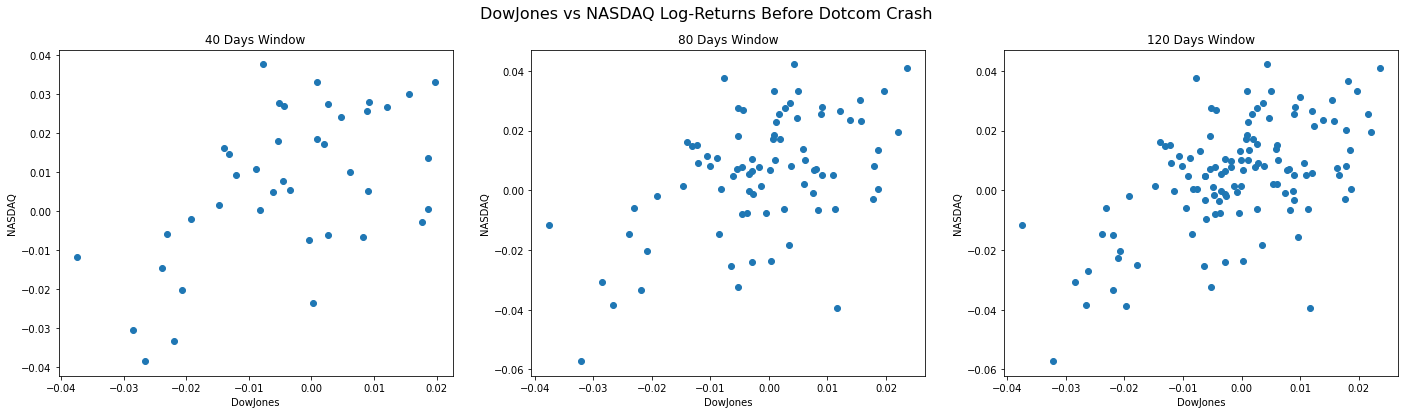

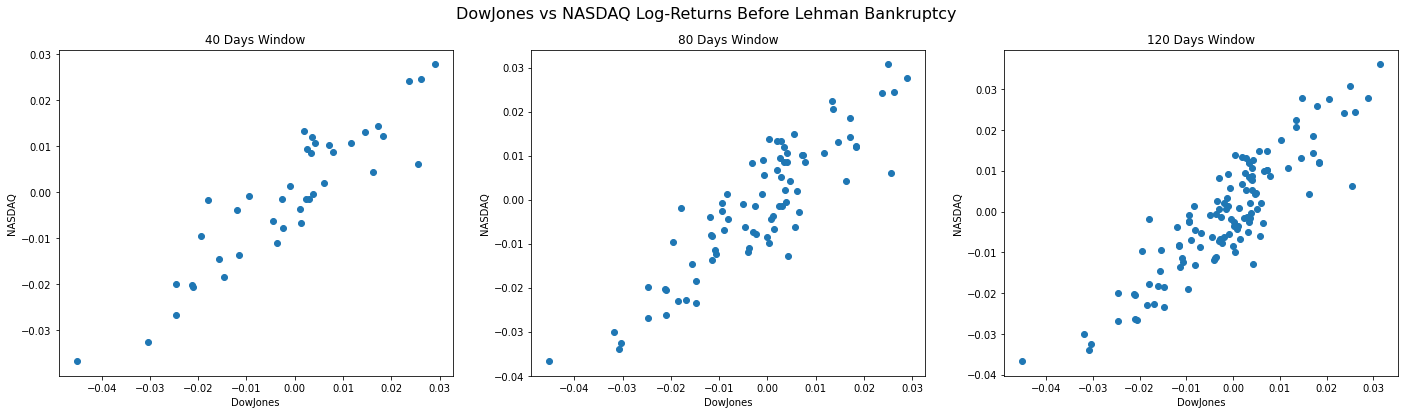

In [ ]:
# Create point clouds
X_dotcom_40 = df_lr[dotcom_idx-40:dotcom_idx][["djia","nasdaq"]].to_numpy()
X_dotcom_80 = df_lr[dotcom_idx-80:dotcom_idx][["djia","nasdaq"]].to_numpy()
X_dotcom_120 = df_lr[dotcom_idx-120:dotcom_idx][["djia","nasdaq"]].to_numpy()
X_lehman_40 = df_lr[lehman_idx-40:lehman_idx][["djia","nasdaq"]].to_numpy()
X_lehman_80 = df_lr[lehman_idx-80:lehman_idx][["djia","nasdaq"]].to_numpy()
X_lehman_120 = df_lr[lehman_idx-120:lehman_idx][["djia","nasdaq"]].to_numpy()

# Plot point clouds
fig, axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("DowJones vs NASDAQ Log-Returns Before Dotcom Crash", fontsize=16)

axs[0].set_title("40 Days Window")
axs[0].scatter(X_dotcom_40[:,0],X_dotcom_40[:,1])
axs[0].set_xlabel("DowJones")
axs[0].set_ylabel("NASDAQ")

axs[1].set_title("80 Days Window")
axs[1].scatter(X_dotcom_80[:,0],X_dotcom_80[:,1])
axs[1].set_xlabel("DowJones")
axs[1].set_ylabel("NASDAQ")

axs[2].set_title("120 Days Window")
axs[2].scatter(X_dotcom_120[:,0],X_dotcom_120[:,1])
axs[2].set_xlabel("DowJones")
axs[2].set_ylabel("NASDAQ")

plt.show()

fig, axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("DowJones vs NASDAQ Log-Returns Before Lehman Bankruptcy", fontsize=16)

axs[0].set_title("40 Days Window")
axs[0].scatter(X_lehman_40[:,0],X_lehman_40[:,1])
axs[0].set_xlabel("DowJones")
axs[0].set_ylabel("NASDAQ")

axs[1].set_title("80 Days Window")
axs[1].scatter(X_lehman_80[:,0],X_lehman_80[:,1])
axs[1].set_xlabel("DowJones")
axs[1].set_ylabel("NASDAQ")

axs[2].set_title("120 Days Window")
axs[2].scatter(X_lehman_120[:,0],X_lehman_120[:,1])
axs[2].set_xlabel("DowJones")
axs[2].set_ylabel("NASDAQ")

plt.show()

> For each of the sub-series defined by the sliding windows, we compute the Rips filtration of the induced point cloud along with the persistence diagram and persistence landscapes. We first apply Rips filtration to all windows and compute their persistence diagrams.

In [ ]:
# First plot the persistence diagrams of point clouds induced by all windows before the two main crisis
# Create point clouds
X_dotcom_40 = df_lr[dotcom_idx-40:dotcom_idx][["djia","nasdaq","russell","sp"]].to_numpy()
X_dotcom_80 = df_lr[dotcom_idx-80:dotcom_idx][["djia","nasdaq","russell","sp"]].to_numpy()
X_dotcom_120 = df_lr[dotcom_idx-120:dotcom_idx][["djia","nasdaq","russell","sp"]].to_numpy()
X_lehman_40 = df_lr[lehman_idx-40:lehman_idx][["djia","nasdaq","russell","sp"]].to_numpy()
X_lehman_80 = df_lr[lehman_idx-80:lehman_idx][["djia","nasdaq","russell","sp"]].to_numpy()
X_lehman_120 = df_lr[lehman_idx-120:lehman_idx][["djia","nasdaq","russell","sp"]].to_numpy()

# Create Rips Complexes
rc_dotcom_40 = gd.RipsComplex(points=X_dotcom_40)
rc_dotcom_80 = gd.RipsComplex(points=X_dotcom_80)
rc_dotcom_120 = gd.RipsComplex(points=X_dotcom_120)
rc_lehman_40 = gd.RipsComplex(points=X_lehman_40)
rc_lehman_80 = gd.RipsComplex(points=X_lehman_80)
rc_lehman_120 = gd.RipsComplex(points=X_lehman_120)

# Compute Simplex Trees
st_dotcom_40 = rc_dotcom_40.create_simplex_tree(max_dimension = 2)
st_dotcom_80 = rc_dotcom_80.create_simplex_tree(max_dimension = 2)
st_dotcom_120 = rc_dotcom_120.create_simplex_tree(max_dimension = 2)
st_lehman_40 = rc_lehman_40.create_simplex_tree(max_dimension = 2)
st_lehman_80 = rc_lehman_80.create_simplex_tree(max_dimension = 2)
st_lehman_120 = rc_lehman_120.create_simplex_tree(max_dimension = 2)

# Apply Rips Filtration
br_dotcom_40 = st_dotcom_40.persistence()
br_dotcom_80 = st_dotcom_80.persistence()
br_dotcom_120 = st_dotcom_120.persistence()
br_lehman_40 = st_lehman_40.persistence()
br_lehman_80 = st_lehman_80.persistence()
br_lehman_120 = st_lehman_120.persistence()

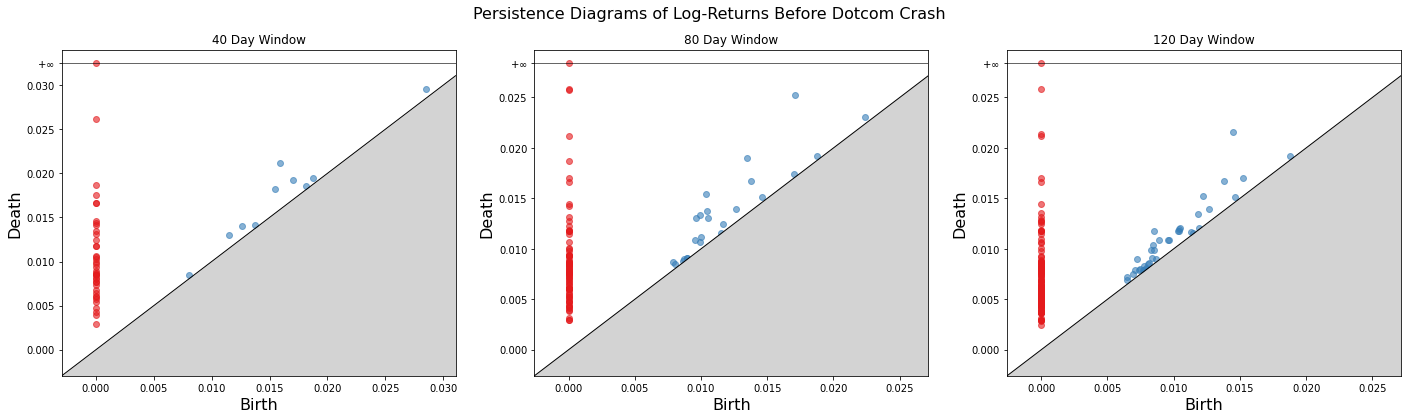

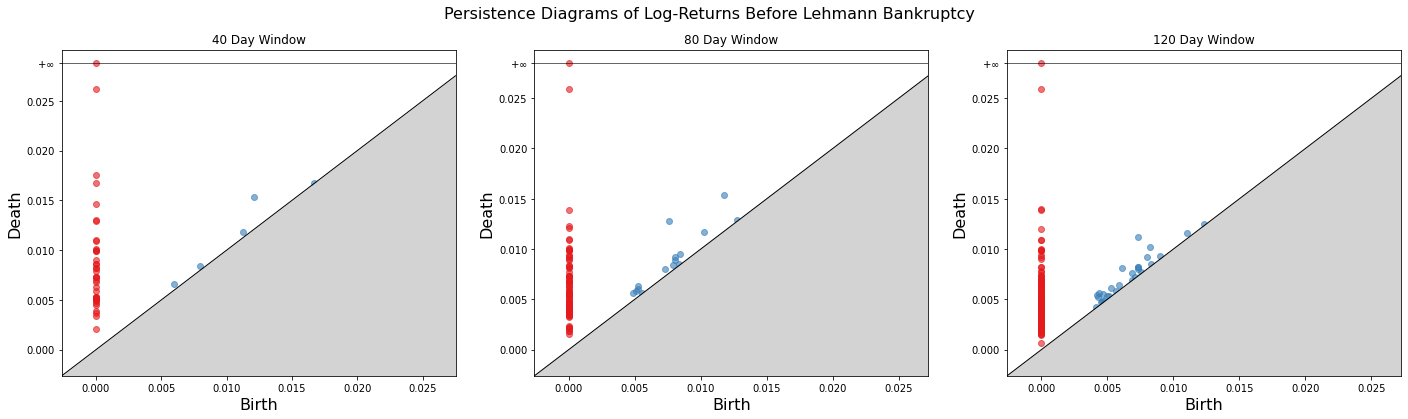

In [ ]:
# Plot results in Figure
fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Persistence Diagrams of Log-Returns Before Dotcom Crash", fontsize=16)

gd.plot_persistence_diagram(br_dotcom_40,axes=axs[0])
axs[0].set_title("40 Day Window")

gd.plot_persistence_diagram(br_dotcom_80,axes=axs[1])
axs[1].set_title("80 Day Window")

gd.plot_persistence_diagram(br_dotcom_120,axes=axs[2])
axs[2].set_title("120 Day Window")

plt.show()


fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Persistence Diagrams of Log-Returns Before Lehmann Bankruptcy", fontsize=16)

gd.plot_persistence_diagram(br_lehman_40,axes=axs[0])
axs[0].set_title("40 Day Window")

gd.plot_persistence_diagram(br_lehman_80,axes=axs[1])
axs[1].set_title("80 Day Window")

gd.plot_persistence_diagram(br_lehman_120,axes=axs[2])
axs[2].set_title("120 Day Window")

plt.show()

> Red dots correspond to connected components while blue dots correspond to loops.
> Let us compute all persistence diagrams for all window sizes.

In [ ]:
# Compute persistence diagrams for all windows
times = []
w_lst = 40,80,120
persistence_diagrams = []

for w in w_lst:
    print("Computing for window size {}".format(w))
    start = time.time()
    persistence_diagrams_w = []
    # Run through each window
    for i in range(len(df_lr)-w+1):
        # Select point cloud according to window
        X = df_lr[["djia","nasdaq","russell","sp"]][i:i+w].to_numpy()
        # Create Rips Complex
        rips_complex = gd.RipsComplex(points=X)
        # Compute Simplex Tree
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        # Apply Rips Filtration
        barcodes_rips = simplex_tree.persistence()
        # Add to list
        persistence_diagrams_w.append(barcodes_rips)
        
    end = time.time()
    times.append(end-start)

    # Add all barcodes to main list
    persistence_diagrams.append(persistence_diagrams_w)

Computing for window size 40
Computing for window size 80
Computing for window size 120


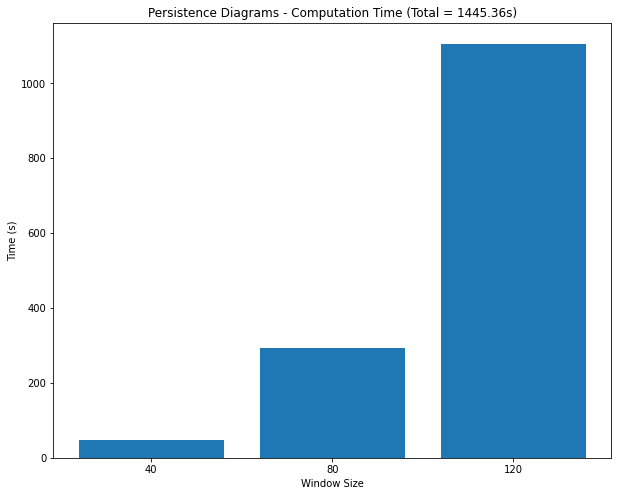

In [ ]:
# Plot computational time chart
plt.figure(figsize=(10,8))
plt.title("Persistence Diagrams - Computation Time (Total = {}s)".format(round(sum(times),2)))
plt.bar(["40","80","120"],times, align="center")
plt.xlabel("Window Size")
plt.ylabel("Time (s)")
plt.show()

> We observe that time for building persistence diagrams increases exponentially with regards to the size of a point cloud. Thus, window sizes cannot be chosen too large because of feasibility issues.

> From these persistence diagrams, we can compute the induced persistence landscapes. We do that both using our method and Gudhi's method and compare the performance in time. We decide upon the following lanscape parameters:


*   $k$ (dimension of homology classes): we will compute persistence landscapes both for connected component ($k=0$) and loop ($k=1$) homology classes.
*   $x_{min},x_{max}$ (interval endpoints): all log-return values reside within a sphere (in dimension 4) of diameter $0.24$. We thus decide to use $x_{min}=0$ and $x_{max}=0.24$.
*   m (number of landscapes): for a good compromise between precision and computation time, we decide to use $m=15$ for all window sizes.
*   n (resolution of the regular grid): given the number of landscapes, a resolution of $n=50$ seems reasonable.



In [ ]:
# Set parameters
xmin,xmax=0,0.24
n = 50
m = 15

In [ ]:
# Compute persistence landscapes for all existing persistence diagrams using our implementation
persistence_landscapes0,persistence_landscapes1 = [],[]
times = []

# Run through each list of persistence diagrams
for i in range(len(persistence_diagrams)):
    print("Computing for window size {}".format(w_lst[i]))
    start = time.time()
    persistence_landscapes0_w, persistence_landscapes1_w = [],[]
    # Run through each persistence diagram and compute the resulting persistence landscapes
    for persistence_diagram in persistence_diagrams[i]:
        persistence_landscape0, persistence_landscape1 = PersistenceLandscape(), PersistenceLandscape()
        persistence_landscape0.build_landscape(persistence_diagram,0,xmin,xmax,n,m)
        persistence_landscape1.build_landscape(persistence_diagram,1,xmin,xmax,n,m)

        # Append to persistence_landscapes lists
        persistence_landscapes0_w.append(persistence_landscape0.landscapes)
        persistence_landscapes1_w.append(persistence_landscape1.landscapes)

    persistence_landscapes0.append(persistence_landscapes0_w)
    persistence_landscapes1.append(persistence_landscapes1_w)
    end = time.time()
    times.append(end-start)

Computing for window size 40
Computing for window size 80
Computing for window size 120


In [ ]:
# Compute persistence landscapes for all existing persistence diagrams using Gudhi's implementation
gd_persistence_landscapes0,gd_persistence_landscapes1 = [],[]
gd_times = []

# Run through each list of persistence diagrams
for i in range(len(persistence_diagrams)):
    print("Computing for window size {}".format(w_lst[i]))
    start = time.time()
    gd_persistence_landscapes0_w, gd_persistence_landscapes1_w = [],[]
    # Run through each persistence diagram and compute the resulting persistence landscapes
    for persistence_diagram in persistence_diagrams[i]:
         # Compute diagonals
        D0 = [np.array([[barcode[0],barcode[1]] for dim,barcode in persistence_diagram if dim == 0 and barcode[1] < math.inf])]
        D1 = [np.array([[barcode[0],barcode[1]] for dim,barcode in persistence_diagram if dim == 1 and barcode[1] < math.inf])]

        # Fit landscape object to Rips diagram
        gd_landscapes0 = Landscape(num_landscapes=m,resolution=n,sample_range=[xmin,xmax]).fit_transform(D0).reshape(m,n)
        gd_landscapes1 = Landscape(num_landscapes=m,resolution=n,sample_range=[xmin,xmax]).fit_transform(D1).reshape(m,n)

        # Append to persistence landscapes list
        gd_persistence_landscapes0_w.append(gd_landscapes0)
        gd_persistence_landscapes1_w.append(gd_landscapes1)

    gd_persistence_landscapes0.append(gd_persistence_landscapes0_w)
    gd_persistence_landscapes1.append(gd_persistence_landscapes1_w)
    end = time.time()
    gd_times.append(end-start)

Computing for window size 40
Computing for window size 80
Computing for window size 120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


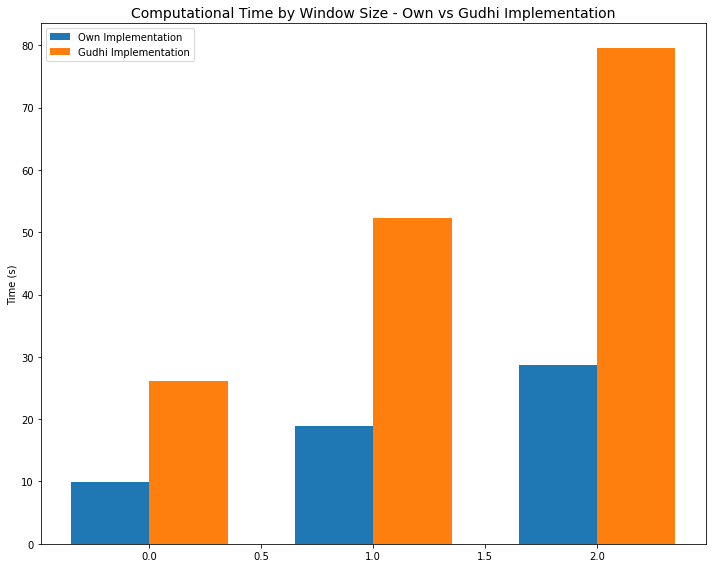

In [ ]:
# Plot comparisons in computational times
labels = ["40","80","120"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, times, width, label='Own Implementation')
rects2 = ax.bar(x + width/2, gd_times, width, label='Gudhi Implementation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Computational Time by Window Size - Own vs Gudhi Implementation', fontsize=14)
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
print("Improvement factor between our implementation and Gudhi's:",round(np.mean(np.divide(gd_times,times)),2))

Improvement factor between our implementation and Gudhi's: 2.71


> Not only did we improve the correctness of Gudhi's persistence landscape computation, but this graph also shows that we are able to improve Gudhi's computation time. On average, our computations were 2.25 times faster than Gudhi. Moreover, it seems like the time gained increases with the size of the point cloud. We have all the reasons to believe our approach to implementing Persistence Landscapes has more advantages than Gudhi's.

> We can now visualize persistence landscapes for each sub-time series and for each window size. Let us do so for the time windows preceding the two major crisis mentionned in the article.

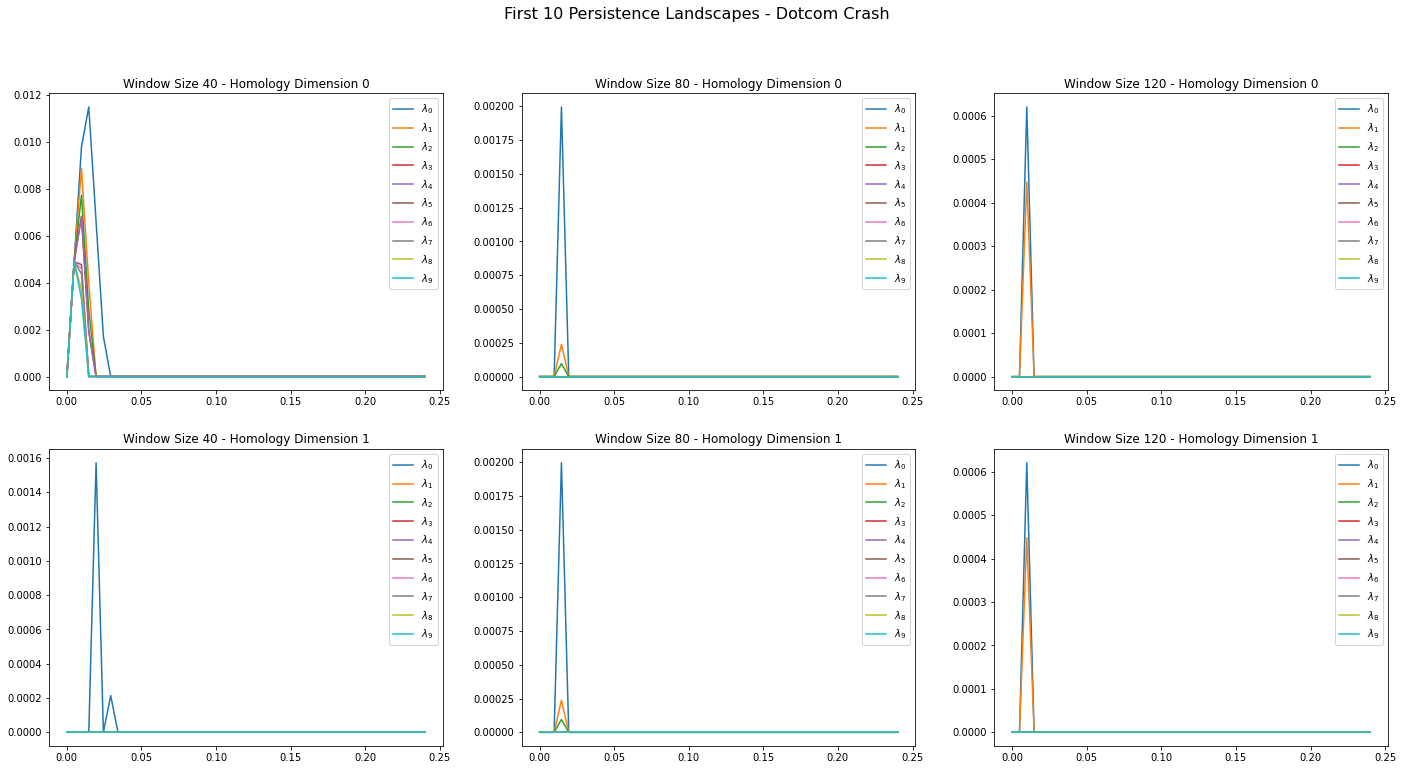

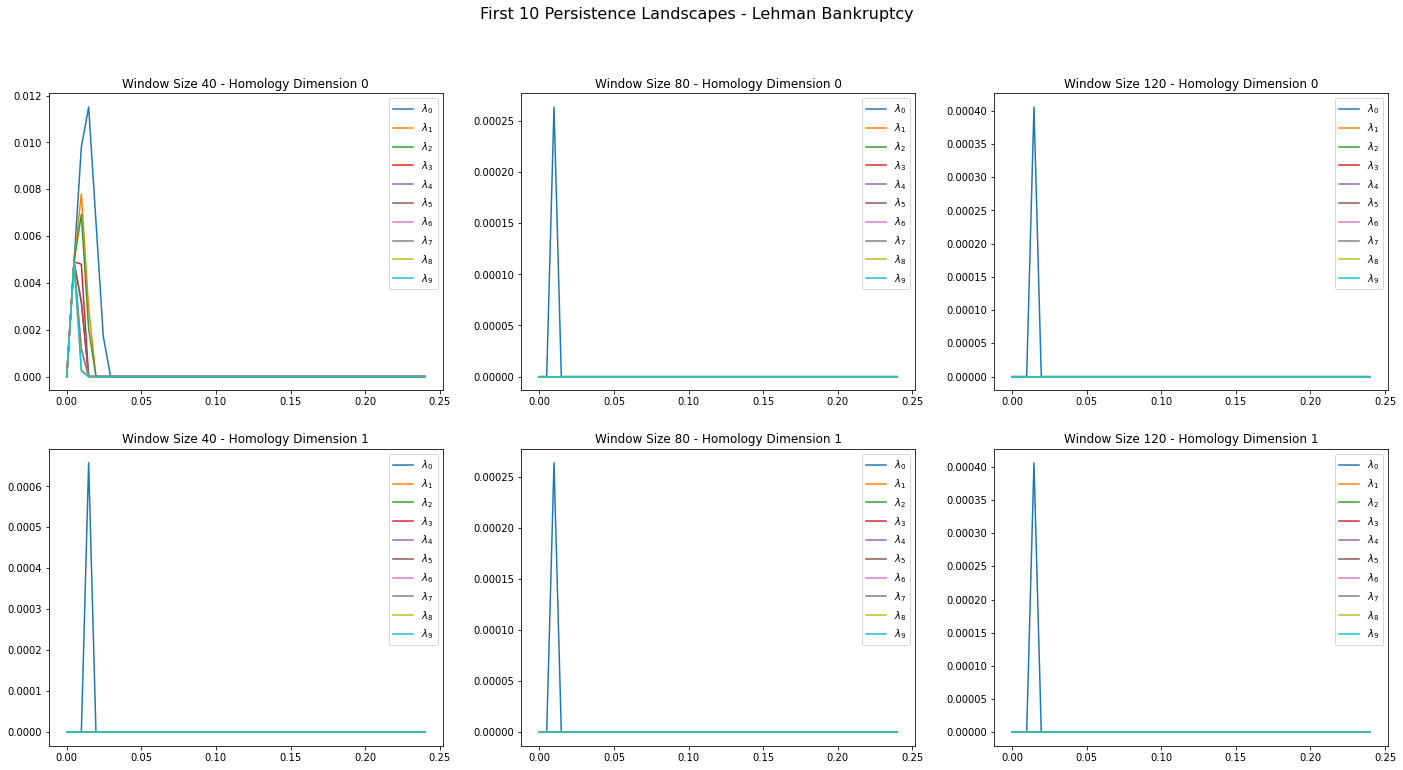

In [ ]:
# Get crisis indexes
dotcom_idx = df_lr[df_lr["Date"] == "2000-03-10"].index[0]
lehman_idx = df_lr[df_lr["Date"] == "2008-09-15"].index[0]

# Compute grid
grid = np.linspace(xmin,xmax,n)

# Get corresponding persistence landscapes
pl0_dotcom_40, pl1_dotcom_40 = persistence_landscapes0[0][dotcom_idx-40], persistence_landscapes1[0][dotcom_idx-40]
pl0_dotcom_80, pl1_dotcom_80 = persistence_landscapes0[0][dotcom_idx-80], persistence_landscapes1[0][dotcom_idx-80]
pl0_dotcom_120, pl1_dotcom_120 = persistence_landscapes0[0][dotcom_idx-120], persistence_landscapes1[0][dotcom_idx-120]
pl0_lehman_40, pl1_lehman_40 = persistence_landscapes0[0][lehman_idx-40], persistence_landscapes1[0][lehman_idx-40]
pl0_lehman_80, pl1_lehman_80 = persistence_landscapes0[0][lehman_idx-80], persistence_landscapes1[0][lehman_idx-80]
pl0_lehman_120, pl1_lehman_120 = persistence_landscapes0[0][lehman_idx-120], persistence_landscapes1[0][lehman_idx-120]

# Plot Dotcom Crash Persistence Landscapes
fig, axs = plt.subplots(2,3,figsize=(24,12))
fig.suptitle("First 10 Persistence Landscapes - Dotcom Crash", fontsize=16)

axs[0,0].set_title("Window Size 40 - Homology Dimension 0")
for i in range(10):
    axs[0,0].plot(grid,pl0_dotcom_40[i,:], label="$\lambda_{}$".format(i))
axs[0,0].legend()

axs[0,1].set_title("Window Size 80 - Homology Dimension 0")
for i in range(10):
    axs[0,1].plot(grid,pl1_dotcom_80[i,:], label="$\lambda_{}$".format(i))
axs[0,1].legend()

axs[0,2].set_title("Window Size 120 - Homology Dimension 0")
for i in range(10):
    axs[0,2].plot(grid,pl1_dotcom_120[i,:], label="$\lambda_{}$".format(i))
axs[0,2].legend()

axs[1,0].set_title("Window Size 40 - Homology Dimension 1")
for i in range(10):
    axs[1,0].plot(grid,pl1_dotcom_40[i,:], label="$\lambda_{}$".format(i))
axs[1,0].legend()

axs[1,1].set_title("Window Size 80 - Homology Dimension 1")
for i in range(10):
    axs[1,1].plot(grid,pl1_dotcom_80[i,:], label="$\lambda_{}$".format(i))
axs[1,1].legend()

axs[1,2].set_title("Window Size 120 - Homology Dimension 1")
for i in range(10):
    axs[1,2].plot(grid,pl1_dotcom_120[i,:], label="$\lambda_{}$".format(i))
axs[1,2].legend()

plt.show()


# Plot Lehman Bankruptcy Persistence Landscapes
fig, axs = plt.subplots(2,3,figsize=(24,12))
fig.suptitle("First 10 Persistence Landscapes - Lehman Bankruptcy", fontsize=16)

axs[0,0].set_title("Window Size 40 - Homology Dimension 0")
for i in range(10):
    axs[0,0].plot(grid,pl0_lehman_40[i,:], label="$\lambda_{}$".format(i))
axs[0,0].legend()

axs[0,1].set_title("Window Size 80 - Homology Dimension 0")
for i in range(10):
    axs[0,1].plot(grid,pl1_lehman_80[i,:], label="$\lambda_{}$".format(i))
axs[0,1].legend()

axs[0,2].set_title("Window Size 120 - Homology Dimension 0")
for i in range(10):
    axs[0,2].plot(grid,pl1_lehman_120[i,:], label="$\lambda_{}$".format(i))
axs[0,2].legend()

axs[1,0].set_title("Window Size 40 - Homology Dimension 1")
for i in range(10):
    axs[1,0].plot(grid,pl1_lehman_40[i,:], label="$\lambda_{}$".format(i))
axs[1,0].legend()

axs[1,1].set_title("Window Size 80 - Homology Dimension 1")
for i in range(10):
    axs[1,1].plot(grid,pl1_lehman_80[i,:], label="$\lambda_{}$".format(i))
axs[1,1].legend()

axs[1,2].set_title("Window Size 120 - Homology Dimension 1")
for i in range(10):
    axs[1,2].plot(grid,pl1_lehman_120[i,:], label="$\lambda_{}$".format(i))
axs[1,2].legend()

plt.show()

> From these figures arise two main observations. First, persistence landscapes for homologies of dimension 1 vanish extremely fast. This is also the case for most other windows which generate a low amount of 1-dimensional homology classes. Second, it also seems like persistence landscapes tend to vanish faster with an increasing window size. This is probably caused by the high density of the point cloud induced by such a window. We will further study the influence of the window size in the following experiments. To compare with the article, the rest of our study will focus on the homology classes of dimension 1. The authors do not specify the reasons that led them to this choice. Most likely, it was motivated by the information loops bring to a cloud of points rather than holes.

> By computing the $L^{1}$ and $L^{2}$ norms of the inferred persistence landscapes, we will compute the daily time series of these measurements. We hope these new signals will help us in identifying specific properties of financial series before market crashes. First, we remind the definition of the $L^p$ norm. Let $p>0$, $\lambda=(\lambda_l)_{l \in \mathbb{N}}$ be persistence landscapes of a given point cloud, then:
$$
\| \lambda \|_p = \left( \sum_{l=1}^{∞} \| λ_l \|^{p}_{p} \right)^{\frac{1}{p}}
$$
We compute the induced time series.

In [ ]:
# We only consider persistence landscapes of 1-dimensional homologies
persistence_landscapes = persistence_landscapes1
w_lst = [40,80,120]

# Run through each persistence landscapes, compute their L1 and L2 norms and store them in a list
L1_norms,L2_norms = [],[]
for i in range(len(persistence_landscapes)):
    L1_norms_w,L2_norms_w = [],[]
    for pl in persistence_landscapes[i]:
          # Compute norms and append in lists
          L1_norms_w.append(np.linalg.norm(pl,ord=1))
          L2_norms_w.append(np.linalg.norm(pl,ord=2))

    # Because of the sliding windows, these series are smaller by a length of w
    # We pad their beginning by w nan values
    L1_norms_w = np.pad(L1_norms_w, (w_lst[i]-1,0), mode="constant", constant_values=np.nan)
    L2_norms_w = np.pad(L2_norms_w, (w_lst[i]-1,0), mode="constant", constant_values=np.nan)

    # Append into final list
    L1_norms.append(L1_norms_w)
    L2_norms.append(L2_norms_w)

In [ ]:
# We can then add these time series as columns of the original dataframe
df_lr["L1_w40"] = L1_norms[0]
df_lr["L1_w80"] = L1_norms[1]
df_lr["L1_w120"] = L1_norms[2]
df_lr["L2_w40"] = L2_norms[0]
df_lr["L2_w80"] = L2_norms[1]
df_lr["L2_w120"] = L2_norms[2]

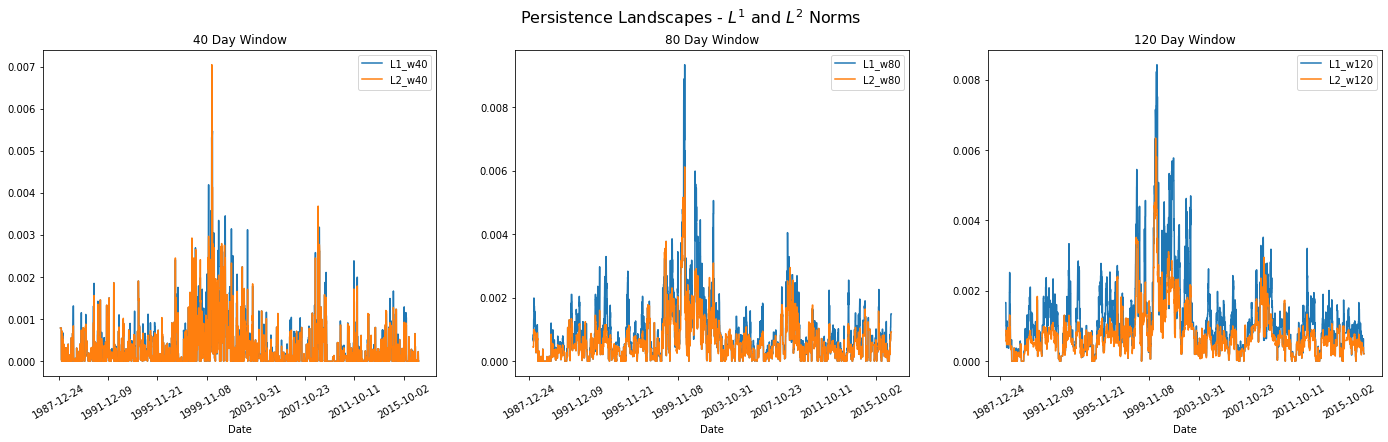

In [ ]:
# Plot Persistence Landscapes Norms over time
fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Persistence Landscapes - $L^1$ and $L^2$ Norms", fontsize=16)

axs[0].set_title("40 Day Window")
df_lr.plot(x="Date",y="L1_w40",rot=30,ax=axs[0])
df_lr.plot(x="Date",y="L2_w40",rot=30,ax=axs[0])

axs[1].set_title("80 Day Window")
df_lr.plot(x="Date",y="L1_w80",rot=30,ax=axs[1])
df_lr.plot(x="Date",y="L2_w80",rot=30,ax=axs[1])

axs[2].set_title("120 Day Window")
df_lr.plot(x="Date",y="L1_w120",rot=30,ax=axs[2])
df_lr.plot(x="Date",y="L2_w120",rot=30,ax=axs[2])

plt.show()

> We also plot the normalized $L^1$ and $L^2$ norms of the persistence landscapes. We normalize the signals by dividing them by their maximum value.

In [ ]:
# Normalize signals
df_lr["L1_w40"] = df_lr["L1_w40"] / df_lr["L1_w40"].max()
df_lr["L1_w80"] = df_lr["L1_w80"] / df_lr["L1_w80"].max()
df_lr["L1_w120"] = df_lr["L1_w120"] / df_lr["L1_w120"].max()
df_lr["L2_w40"] = df_lr["L2_w40"] / df_lr["L2_w40"].max()
df_lr["L2_w80"] = df_lr["L2_w80"] / df_lr["L2_w80"].max()
df_lr["L2_w120"] = df_lr["L2_w120"] / df_lr["L2_w120"].max()

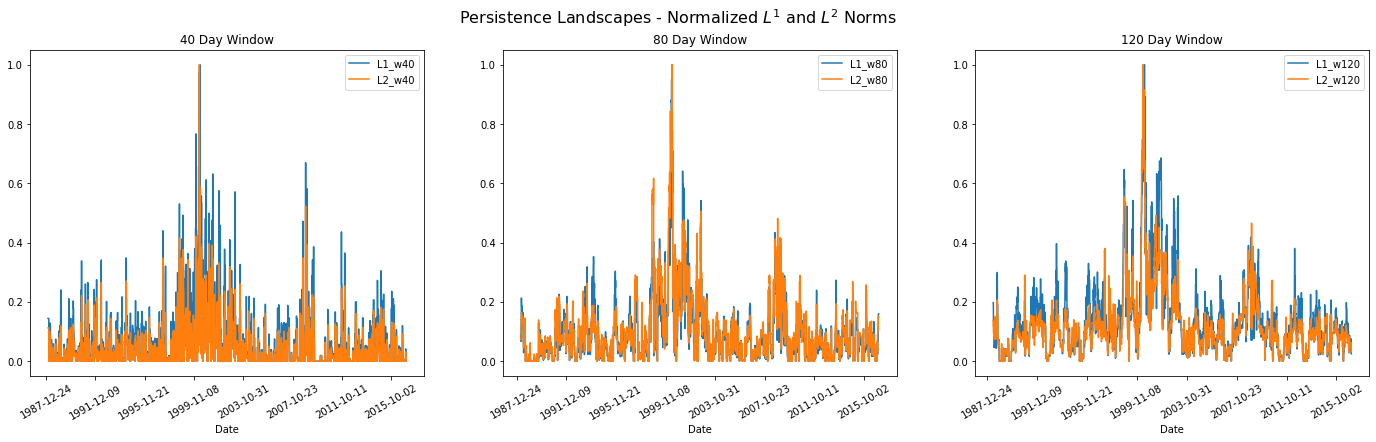

In [ ]:
# Plot the normalized signals
fig,axs = plt.subplots(1,3,figsize=(24,6))
fig.suptitle("Persistence Landscapes - Normalized $L^1$ and $L^2$ Norms", fontsize=16)

axs[0].set_title("40 Day Window")
df_lr.plot(x="Date",y="L1_w40",rot=30,ax=axs[0])
df_lr.plot(x="Date",y="L2_w40",rot=30,ax=axs[0])

axs[1].set_title("80 Day Window")
df_lr.plot(x="Date",y="L1_w80",rot=30,ax=axs[1])
df_lr.plot(x="Date",y="L2_w80",rot=30,ax=axs[1])

axs[2].set_title("120 Day Window")
df_lr.plot(x="Date",y="L1_w120",rot=30,ax=axs[2])
df_lr.plot(x="Date",y="L2_w120",rot=30,ax=axs[2])

plt.show()

> Similarly to the study led by the article, we observe that our $L^1$ and $L^2$ signals differ significantly. Indeed, both signals seem to produce the same up- and down-trends, especially with increasing window sizes. Moreover, high values of $w$ produce smoother signals while smaller values produce signals with high noise and many vanishing values. The latter appear for small window sizes because of the lack of loop structures in smaller cloud points. As the size of a cloud point increases (and consequently the window size) appear more loop homology classes and less vanishing persistence landscapes.

> We now plot the signals in the 3 years preceding the Dotcom Crash (03/10/2000) and the Lehman Bankruptcy (09/15/2008). We analyze the behaviour of the $L^1$ and $L^2$ norms before these major financial crisis.

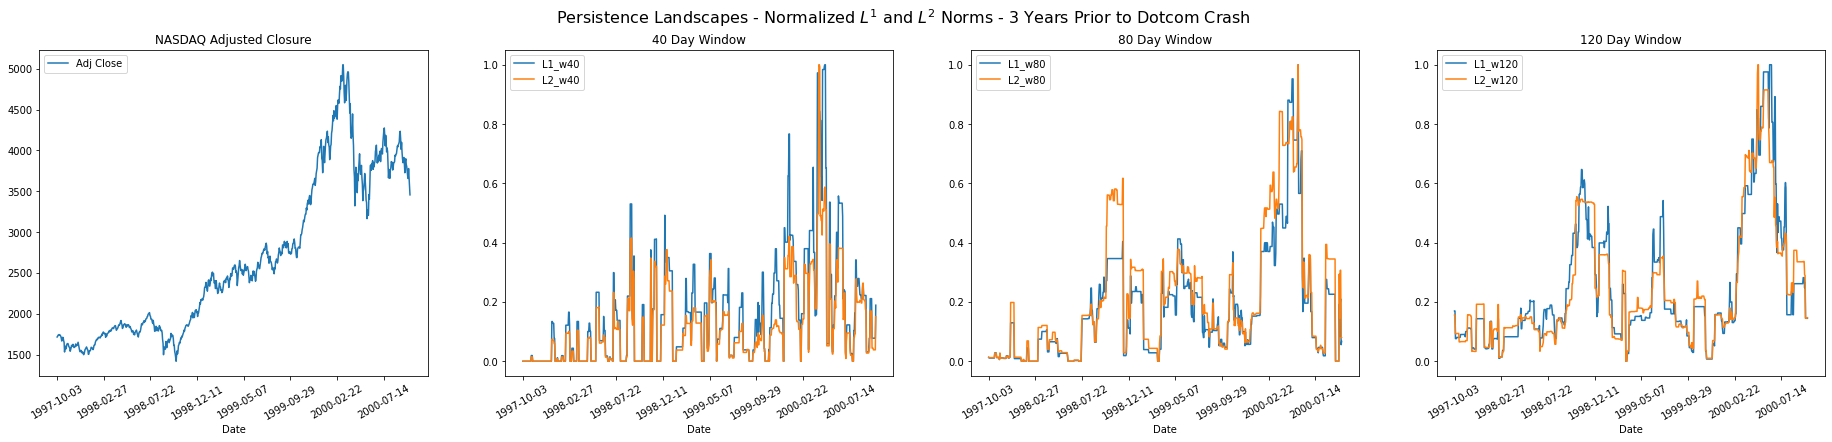

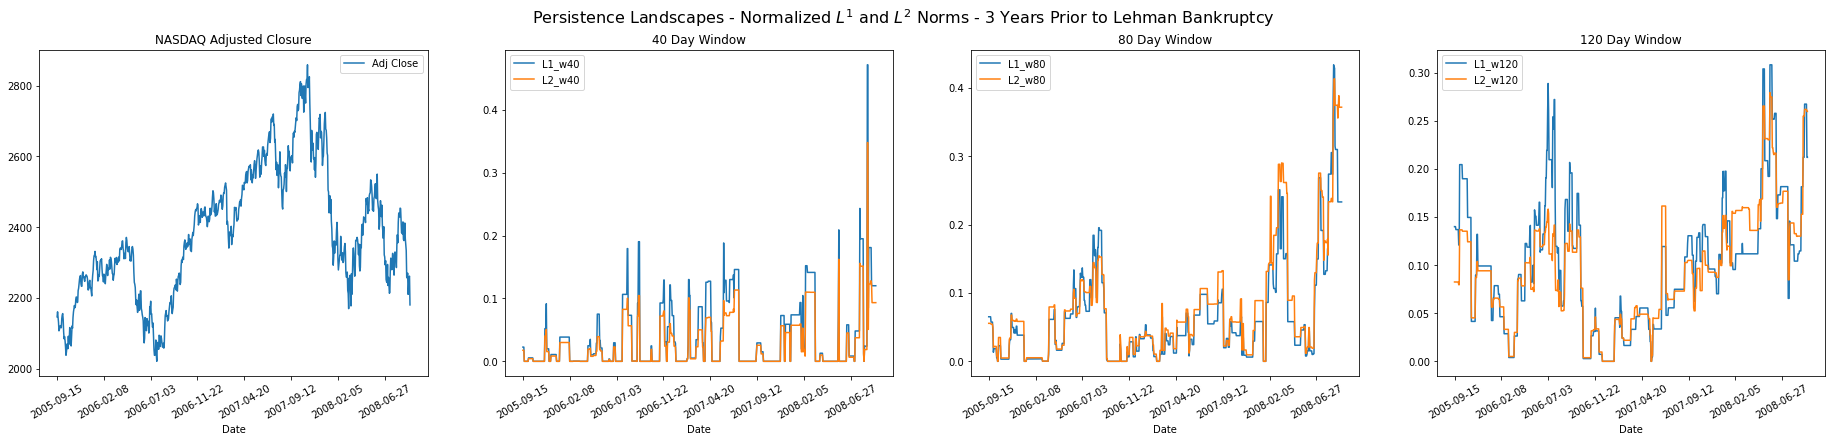

In [ ]:
# Select 3 years prior to crisis
df_dotcom = df_lr[(df_lr["Date"] <= "2000-10-03") & (df_lr["Date"] >= "1997-10-03")]
df_lehman = df_lr[(df_lr["Date"] <= "2008-09-15") & (df_lr["Date"] >= "2005-09-15")]
df_nasdaq_dotcom = df_nasdaq[(df_nasdaq["Date"] <= "2000-10-03") & (df_nasdaq["Date"] >= "1997-10-03")]
df_nasdaq_lehman = df_nasdaq[(df_nasdaq["Date"] <= "2008-09-15") & (df_nasdaq["Date"] >= "2005-09-15")]

# Plot a figure for each crisis
# Dotcom Crash
fig,axs = plt.subplots(1,4,figsize=(32,6))
fig.suptitle("Persistence Landscapes - Normalized $L^1$ and $L^2$ Norms - 3 Years Prior to Dotcom Crash", fontsize=16)

axs[0].set_title("NASDAQ Adjusted Closure")
df_nasdaq_dotcom.plot(x="Date",y="Adj Close",rot=30,ax=axs[0])

axs[1].set_title("40 Day Window")
df_dotcom.plot(x="Date",y="L1_w40",rot=30,ax=axs[1])
df_dotcom.plot(x="Date",y="L2_w40",rot=30,ax=axs[1])

axs[2].set_title("80 Day Window")
df_dotcom.plot(x="Date",y="L1_w80",rot=30,ax=axs[2])
df_dotcom.plot(x="Date",y="L2_w80",rot=30,ax=axs[2])

axs[3].set_title("120 Day Window")
df_dotcom.plot(x="Date",y="L1_w120",rot=30,ax=axs[3])
df_dotcom.plot(x="Date",y="L2_w120",rot=30,ax=axs[3])

plt.show()

# Lehman Bankruptcy
fig,axs = plt.subplots(1,4,figsize=(32,6))
fig.suptitle("Persistence Landscapes - Normalized $L^1$ and $L^2$ Norms - 3 Years Prior to Lehman Bankruptcy", fontsize=16)

axs[0].set_title("NASDAQ Adjusted Closure")
df_nasdaq_lehman.plot(x="Date",y="Adj Close",rot=30,ax=axs[0])

axs[1].set_title("40 Day Window")
df_lehman.plot(x="Date",y="L1_w40",rot=30,ax=axs[1])
df_lehman.plot(x="Date",y="L2_w40",rot=30,ax=axs[1])

axs[2].set_title("80 Day Window")
df_lehman.plot(x="Date",y="L1_w80",rot=30,ax=axs[2])
df_lehman.plot(x="Date",y="L2_w80",rot=30,ax=axs[2])

axs[3].set_title("120 Day Window")
df_lehman.plot(x="Date",y="L1_w120",rot=30,ax=axs[3])
df_lehman.plot(x="Date",y="L2_w120",rot=30,ax=axs[3])

plt.show()

> Similarly to the observations made in the article, we observe that both $L^1$ and $L^2$ norms demonstrate strong fore-shocks prior to the primary peaks. While the article only mentions $L^1$ signals, we observe the same behaviour with the $L^2$ norm. In fact, while $L^1$ norms have very abrupt peaks, the ones from the $L^2$ signals are squarer and may be easier to identify. Moreover, we make the same observations as above regarding window sizes. With an increasing window size, signals become smoother thus up- and down-trends become much more identifiable. In the same time, less fore-shocks appear but the most singnificant ones also become easier to identify. Therefore, with higher window sizes, we are able to preserve the most relevant information while remove most of the irrelevant one. This suggests a compromise must be found between precision and computational complexity of high window sizes. Finally, we do not observe any evident shift of the prior maximum towards the later dates.

> Like in the article, we can now apply the standard technique and analyze the leading statistical indicators of the $L^p$ norms of persistence landscapes. Inspired from [Guttal et. al.](https://www.researchgate.net/publication/290432575_Lack_of_Critical_Slowing_Down_Suggests_that_Financial_Meltdowns_Are_Not_Critical_Transitions_yet_Rising_Variability_Could_Signal_Systemic_Risk), we compute the variance, the average spectral densities at low frequencies of our signal and the first lag of the Auto-Correlation Function (ACF). All of these information are computed over a period of 250 trading days prior to the dates of the two main market crashes. Note that no indication is given regarding the range that is considered for low-frequencies of the spectral densities (neither in the main article or Guttal et. al.). We thus decide upon a range of the first 10% of frequencies.

In [ ]:
# Get indexes of the crisis dates
dotcom_idx = df_lr[df_lr["Date"] == "2000-03-10"].index[0]
lehman_idx = df_lr[df_lr["Date"] == "2008-09-15"].index[0]

# Instantiate lists which will contain statistical properties mentionned above
var_dotcom_L1,var_dotcom_L2,var_lehman_L1,var_lehman_L2 = np.zeros((3,250)),np.zeros((3,250)),np.zeros((3,250)),np.zeros((3,250))
spec_dotcom_L1,spec_dotcom_L2,spec_lehman_L1,spec_lehman_L2 = np.zeros((3,250)),np.zeros((3,250)),np.zeros((3,250)),np.zeros((3,250))
acf_dotcom_L1,acf_dotcom_L2,acf_lehman_L1,acf_lehman_L2 = np.zeros((3,250)),np.zeros((3,250)),np.zeros((3,250)),np.zeros((3,250))

# Run through each window and compute the statistical properties for both crashes
for prior_day in reversed(range(250)):
    # Compute windows of size 500
    df_window_dotcom = df_lr[dotcom_idx-prior_day-500:dotcom_idx-prior_day]
    df_window_lehman = df_lr[lehman_idx-prior_day-500:lehman_idx-prior_day]

    # Compute statistical properties for all Lp signals and all window sizes
    for i,w in enumerate([40,80,120]):
        # Compute variances
        var_dotcom_L1[i,249-prior_day] = df_window_dotcom["L1_w{}".format(w)].var()
        var_dotcom_L2[i,249-prior_day] = df_window_dotcom["L2_w{}".format(w)].var()
        var_lehman_L1[i,249-prior_day] = df_window_lehman["L1_w{}".format(w)].var()
        var_lehman_L2[i,249-prior_day] = df_window_lehman["L2_w{}".format(w)].var()

        # Compute average spectral density at low frequencies
        _,den_dotcom_L1 = signal.periodogram(df_window_dotcom["L1_w{}".format(w)])
        _,den_dotcom_L2 = signal.periodogram(df_window_dotcom["L2_w{}".format(w)])
        _,den_lehman_L1 = signal.periodogram(df_window_lehman["L1_w{}".format(w)])
        _,den_lehman_L2 = signal.periodogram(df_window_lehman["L2_w{}".format(w)])

        spec_dotcom_L1[i,249-prior_day] = np.mean(den_dotcom_L1[:25])
        spec_dotcom_L2[i,249-prior_day] = np.mean(den_dotcom_L2[:25])
        spec_lehman_L1[i,249-prior_day] = np.mean(den_lehman_L1[:25])
        spec_lehman_L2[i,249-prior_day] = np.mean(den_lehman_L2[:25])

        # Compute first lag of the ACF
        acf_dotcom_L1[i,249-prior_day] = acf(df_window_dotcom["L1_w{}".format(w)])[1]
        acf_dotcom_L2[i,249-prior_day] = acf(df_window_dotcom["L2_w{}".format(w)])[1]
        acf_lehman_L1[i,249-prior_day] = acf(df_window_lehman["L1_w{}".format(w)])[1]
        acf_lehman_L2[i,249-prior_day] = acf(df_window_lehman["L2_w{}".format(w)])[1]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


> We now plot the resulting graphs for both crisis.

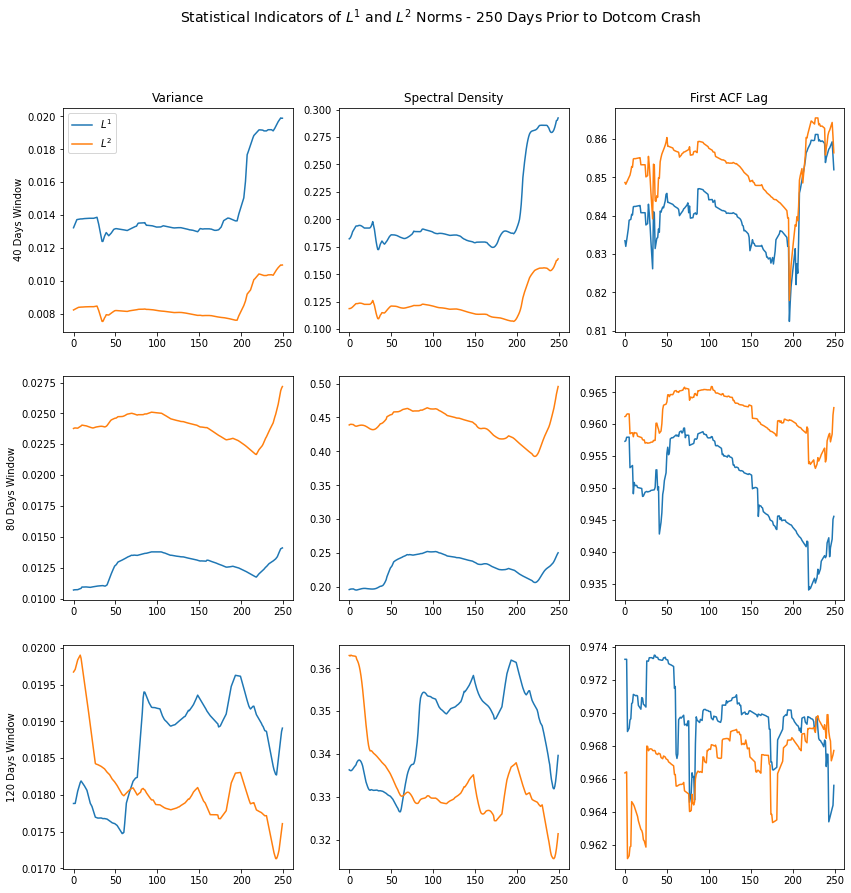

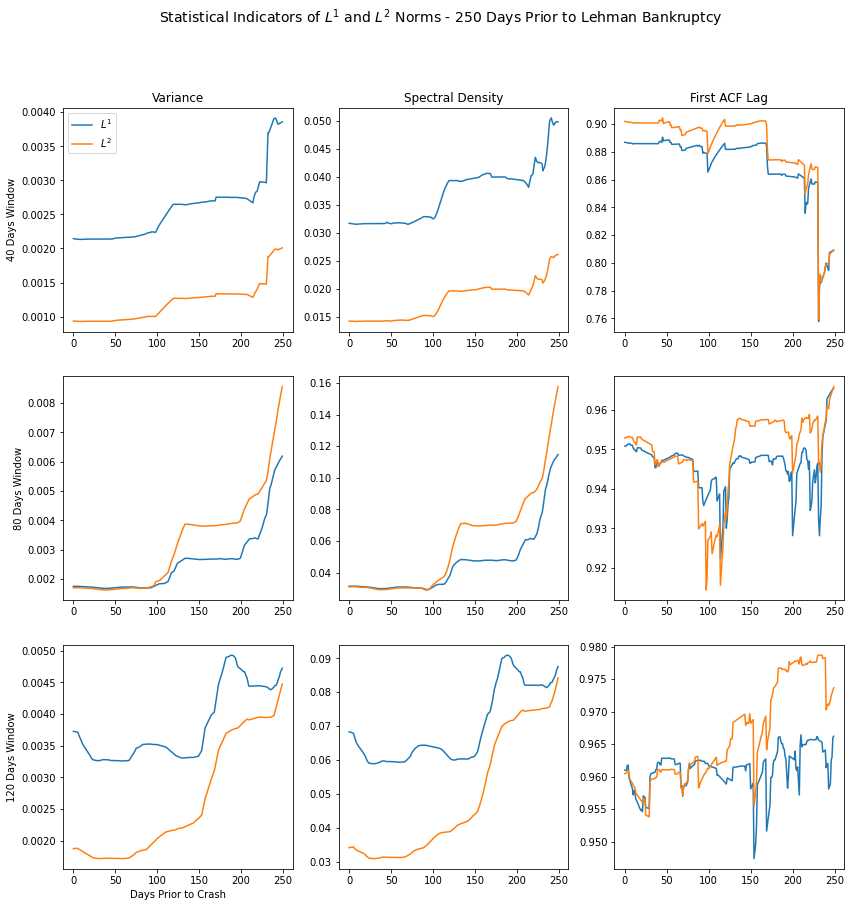

In [ ]:
# Plot figures for both crisis
# Dotcom Crash
fig,axs = plt.subplots(3,3,figsize=(14,14))
fig.suptitle("Statistical Indicators of $L^1$ and $L^2$ Norms - 250 Days Prior to Dotcom Crash", fontsize=14)

axs[0,0].set_title("Variance")
axs[0,0].plot(var_dotcom_L1[0,:], label="$L^1$")
axs[0,0].plot(var_dotcom_L2[0,:], label="$L^2$")
axs[0,0].set_ylabel("40 Days Window")
axs[0,0].legend()

axs[0,1].set_title("Spectral Density")
axs[0,1].plot(spec_dotcom_L1[0,:])
axs[0,1].plot(spec_dotcom_L2[0,:])

axs[0,2].set_title("First ACF Lag")
axs[0,2].plot(acf_dotcom_L1[0,:])
axs[0,2].plot(acf_dotcom_L2[0,:])

axs[1,0].plot(var_dotcom_L1[1,:])
axs[1,0].plot(var_dotcom_L2[1,:])
axs[1,0].set_ylabel("80 Days Window")

axs[1,1].plot(spec_dotcom_L1[1,:])
axs[1,1].plot(spec_dotcom_L2[1,:])

axs[1,2].plot(acf_dotcom_L1[1,:])
axs[1,2].plot(acf_dotcom_L2[1,:])

axs[2,0].plot(var_dotcom_L1[2,:])
axs[2,0].plot(var_dotcom_L2[2,:])
axs[2,0].set_ylabel("120 Days Window")

axs[2,1].plot(spec_dotcom_L1[2,:])
axs[2,1].plot(spec_dotcom_L2[2,:])

axs[2,2].plot(acf_dotcom_L1[2,:])
axs[2,2].plot(acf_dotcom_L2[2,:])

plt.show()


# Lehman Bankruptcy
fig,axs = plt.subplots(3,3,figsize=(14,14))
fig.suptitle("Statistical Indicators of $L^1$ and $L^2$ Norms - 250 Days Prior to Lehman Bankruptcy", fontsize=14)

axs[0,0].set_title("Variance")
axs[0,0].plot(var_lehman_L1[0,:], label="$L^1$")
axs[0,0].plot(var_lehman_L2[0,:], label="$L^2$")
axs[0,0].set_ylabel("40 Days Window")
axs[0,0].legend()

axs[0,1].set_title("Spectral Density")
axs[0,1].plot(spec_lehman_L1[0,:])
axs[0,1].plot(spec_lehman_L2[0,:])

axs[0,2].set_title("First ACF Lag")
axs[0,2].plot(acf_lehman_L1[0,:])
axs[0,2].plot(acf_lehman_L2[0,:])

axs[1,0].plot(var_lehman_L1[1,:])
axs[1,0].plot(var_lehman_L2[1,:])
axs[1,0].set_ylabel("80 Days Window")

axs[1,1].plot(spec_lehman_L1[1,:])
axs[1,1].plot(spec_lehman_L2[1,:])

axs[1,2].plot(acf_lehman_L1[1,:])
axs[1,2].plot(acf_lehman_L2[1,:])

axs[2,0].plot(var_lehman_L1[2,:])
axs[2,0].plot(var_lehman_L2[2,:])
axs[2,0].set_ylabel("120 Days Window")
axs[2,0].set_xlabel("Days Prior to Crash")

axs[2,1].plot(spec_lehman_L1[2,:])
axs[2,1].plot(spec_lehman_L2[2,:])

axs[2,2].plot(acf_lehman_L1[2,:])
axs[2,2].plot(acf_lehman_L2[2,:])

plt.show()

> Our results are extremely similar to the ones produced by the article. We are able to identify the same characteristics of variance and spectral density in the $L^1$ and $L^2$ norm curves, though we will show they have difficulty to generalize to all window sizes. 

*   First, similarly to the article, we do not detect any characteristic behaviour regarding first lags of the ACFs prior to both crashes. In fact, their evolution over time seems to be quite noisy and irregular. 
*   Second, like in the article, we are able to detect uptrends in the variance and spectral density properties of the $L^1$ and $L^2$ norm series. These uptrends are extremely abrupt and, in both cases, begin around 50 days prior to the crash. It is reasonnable to suppose these uptrends become detectable at least 10 days prior to the crash which represents a significant advantage in financial terms.
*   Finally, the experiments led above suggest there is no correct window size, but rather that several window sizes could prove complementary in such an analysis. Indeed, though uptrends are identifiable in both crashes using windows of 40 days, we observe that higher window sizes in the case of the Lehman Bankruptcy make the uptrends much more identifiable. Indeed, in the case of the 80 days window, the uptrends in variance and spectral density are much more abrupt and identifiable than for the smaller window. Moreover, while using a 120 day window, we observe an extremely neat increase in variance and spectral density for the $L^2$ norm. This trend initiates 100 days prior to the crash and is clearly identifiable at least 75 days prior to the crash. 
*   In conclusion, our observations suggest that working with several window sizes offer a great opportunity to identify major economic crises. Indeed, while the article considers using windows of 50 and 100 days produces the same results, we have shown that, by using three windows of sizes 40, 80 and 120, both the Dotcom Crash and the Lehman Bankruptcy would have been more predictable. This means that not only uptrends in the statisical properties of $L^1$ and $L^2$ norms were clearer to identify, but they would also have been identified much earlier.